In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

from transformers.custom_transformers import *

In [3]:
data = pd.read_csv("../data/Titanic-Dataset.csv")
data.columns = data.columns.str.lower()

X = data.drop(columns=["survived"])
y = data["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
    shuffle=True
)

In [4]:
feature_engineering = ColumnTransformer([
    ('pclass', PClassEncoder(), ['pclass']),
    ('name', NameExtractor(), ['name']),
    ('sex', SexEncoder(), ['sex']),
    ('sibsp', SibspBinning(), ['sibsp']),
    ('parch', ParchBinning(), ['parch']),
    ('ticket', TicketExtractorAdvanced(top_k=5), ['ticket']),
    ('fare', FareBinning(method='quantile', q=4), ['fare']),
    ('age', AgeImmputer(), ['age']),
    ('embarked', EmbarkedEncoder(), ['embarked']),
], remainder='drop')

preprocess = Pipeline([
    ('feature_eng', feature_engineering),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [5]:
xgb_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [2, 3],
    'model__learning_rate': [0.01, 0.05],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8],
    'model__reg_lambda': [1, 5],
    'model__reg_alpha': [0, 1]
}

xgb_search = GridSearchCV(
    xgb_pipeline,
    param_grid=xgb_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_train, y_train)

print("XGB Best ROC-AUC (CV):", xgb_search.best_score_)
print("XGB Best Params:", xgb_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
XGB Best ROC-AUC (CV): 0.8695271294831223
XGB Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 1, 'model__subsample': 0.8}


In [6]:
best_pipeline = xgb_search.best_estimator_

y_prob = best_pipeline.predict_proba(X_test)[:, 1]

threshold = 0.4
y_pred = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC (Test):", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       165
           1       0.78      0.75      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268

ROC-AUC (Test): 0.8719035010297146


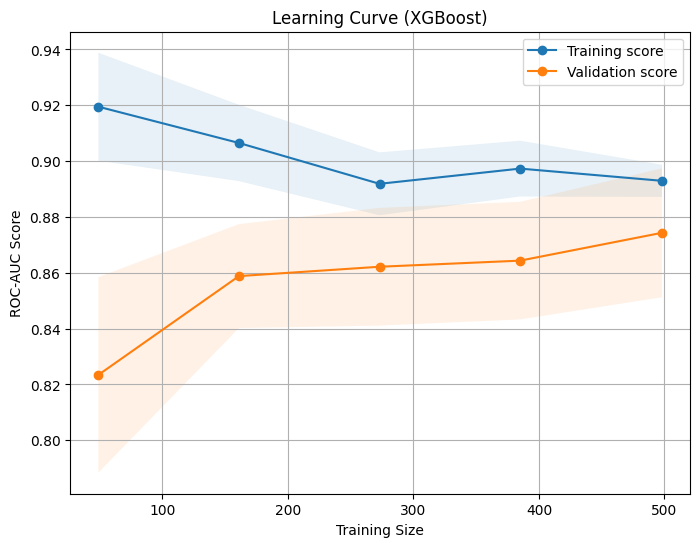

In [7]:
train_sizes = np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline,
    X_train,
    y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', label='Validation score')

plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.1)

plt.fill_between(train_sizes,
                 val_mean - val_std,
                 val_mean + val_std,
                 alpha=0.1)

plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Size')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid(True)
output_path = "../outputs/figures/learning_curve.png"
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()

In [8]:
joblib.dump(best_pipeline, "../outputs/models/titanic_xgb_model.pkl")
print("Model saved as titanic_xgb_model.pkl")

Model saved as titanic_xgb_model.pkl
